In [3]:
import numpy as np
import torch
import os
import pandas as pd
from tqdm import tqdm
from model import GPTConfig, GPT

In [ ]:
# data
dataset = 'openwebtext'
gradient_accumulation_steps = 5 * 8 # used to simulate larger batch sizes
batch_size = 12 # if gradient_accumulation_steps > 1, this is the micro-batch size
block_size = 1024

device = 'mps'
device_type = 'cuda' if 'cuda' in device else 'cpu' 

In [ ]:
# poor man's data loader
data_dir = os.path.join('data', dataset)
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
    else:
        data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [ ]:
x, y = get_batch('val')
print('x.shape =', x.shape, 'y.shape =', y.shape)

In [ ]:
# load model
out_dir = 'out-gpt2-cepred'
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)

gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']

unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)

In [ ]:
model.eval()
model.to(device)
compile = False
if compile:
    model = torch.compile(model)

In [ ]:
print(model.ce_predictor)
print(model.ce_predictor[0].weight.shape)
print(model.ce_predictor[0].weight.data.cpu().numpy().mean())

In [ ]:
print(model.lm_head.weight.shape)
print(model.lm_head.weight.data.cpu().numpy().mean())

In [ ]:
linear = torch.nn.Linear(768,1)
print(linear.weight.data.cpu().numpy().mean())

In [ ]:
# do some inference
with torch.no_grad():
    logits, ce_pred, loss = model(x)

print('logits.shape =', logits.shape)
print('ce_pred.shape =', ce_pred.shape)
print('loss =', loss)

In [ ]:
# print(ce_pred)

In [ ]:
with torch.no_grad():
    logits, ce_pred, loss = model(x)

In [ ]:
def forward(model, idx):
    device = idx.device
    b, t = idx.size()
    assert t <= model.config.block_size, f"Cannot forward sequence of length {t}, block size is only {model.config.block_size}"
    pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

    # forward the GPT model itself
    tok_emb = model.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
    pos_emb = model.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
    x = model.transformer.drop(tok_emb + pos_emb)
    for block in model.transformer.h:
        x = block(x)
    x = model.transformer.ln_f(x)

    logits = model.lm_head(x)
    ce_pred = model.ce_predictor(x)

    return logits, ce_pred

In [ ]:
# test forward()
logits, ce_pred = forward(model, x)

print('logits.shape =', logits.shape)
print('ce_pred.shape =', ce_pred.shape)

print(ce_pred[:,:5,0])

In [ ]:
# get some ce_pred data and plot
eval_iters = 100
ce_pred_list = []
with torch.no_grad():
    for i in tqdm(range(eval_iters)):
        x, _ = get_batch('val')
        _, ce_pred = forward(model, x)
        ce_pred_list.append(ce_pred.cpu().numpy())

In [ ]:
# save ce_pred_data
ce_pred_data = np.concatenate(ce_pred_list, axis=0)
print(ce_pred_data.shape)
# remove last dimension
ce_pred_data = ce_pred_data[:,:,0]
print(ce_pred_data.shape)

np.save('ce_pred_data.npy', ce_pred_data)

In [4]:
# plot
import rpy2 

%load_ext rpy2.ipython
%R require("ggplot2")
%R require("data.table")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


1


In [5]:
ce_pred_data = np.load('ce_pred_data.npy')

df_pred = pd.DataFrame(ce_pred_data)
# df_pred

In [49]:
%%R -i df_pred

dt <- data.table(df_pred)
dt$sid = 1:nrow(dt)
dt.melt <- melt(dt, id.vars = "sid", variable.name = "pos", value.name = "ce_pred")
# dt.melt
nrow(dt.melt)

dt.stat <- dt.melt[, .(mean=mean(ce_pred), upper=mean(ce_pred)+sd(ce_pred), lower=mean(ce_pred)-sd(ce_pred)), by = pos]
dt.stat

# slow
# dt.stat$pos = as.numeric(dt.stat$pos)
# m <- lm(mean ~ pos, data = dt.stat)
# summary(m)

dt.stat$pos <- as.numeric(dt.stat$pos)
p <- ggplot(dt.stat, aes(x = pos)) + 
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.5, fill = "grey70") + 
    geom_line(aes(y = mean), group=1) + 
    labs(x = "Position", y = "CE Pred")
ggsave("cepred_vs_pos_meanerror.pdf", p, width=5, height=5)

# dt.melt$pos <- as.numeric(dt.melt$pos)
# p1 <- ggplot(dt.melt, aes(x = pos, y = ce_pred)) +
#     geom_smooth(method = "gam") + 
#     labs(x = "Position", y = "CE Pred")
# ggsave("cepred_vs_pos_smooth.pdf", p1, width=5, height=5)

p2 <- ggplot(dt.stat, aes(x = pos, y = mean)) +
    geom_point()  + 
    labs(x = "Position", y = "CE Pred")
ggsave("cepred_vs_pos_point.pdf", p2, width=5, height=5)

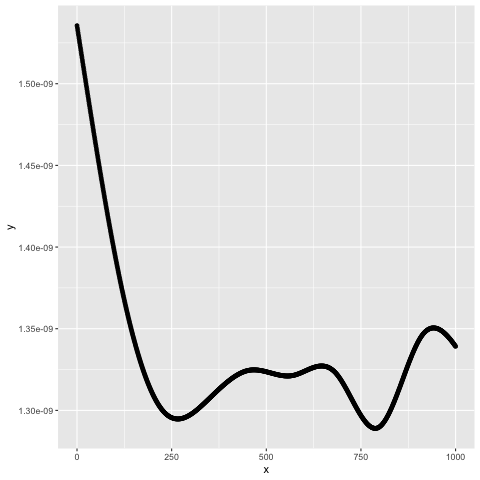

In [39]:
%%R -i df_pred

# Fit GAM model
require("mgcv")

dt <- data.table(df_pred)
dt$sid = 1:nrow(dt)
dt.melt <- melt(dt, id.vars = "sid", variable.name = "pos", value.name = "ce_pred")

setkey(dt.melt, sid)
head(dt.melt)

dt.melt$pos <- as.numeric(dt.melt$pos)
gam <- gam(ce_pred ~ s(pos, bs="cs"), data = dt.melt)

get_GAM_pred <- function(gam_model, n_interp = 500) {
    x <- data.table(pos = seq(0, 1000, 1))
    y <- as.numeric(predict(gam_model, x))
    d <- data.table(x = x$pos, y = y)
    d
}

dt.pred <- get_GAM_pred(gam)
dt.pred

# Plot
p <- ggplot(dt.pred, aes(x = x, y = y)) + geom_point()
p